<h1 style="text-align: center;">Breaking RSA: An Implementation of Shor's Algorithm in Quantum Cryptography</h1>
<br>
<p style="text-align: center;"><strong>Prepared for:</strong> Dr. Sultan Almuhammadi</p>
<p style="text-align: center;"><strong>Prepared by:</strong> Ahmed Almalki</p>
<hr>

# What Shor Algorithm
- Developed by Peter Shor in `1994`.
- It is quantum algorithm for integer factorization.
- The objective is to find prime factors of a compsite number `N`.
- Significantly impacts cryptography.

<img src="//raw.githubusercontent.com/qiskit-community/qiskit-textbook/0ae905083ec3872d7ddc6bb4001d5468f476d93f/content/ch-algorithms/images/shor_circuit_1.svg">

# Build `Controlled U Gate`
- Identify `n` and `m` qubits lengths.
- Determine if the given `a` is accepted value.
- Identify the required x gates by `a` XOR `1` 
- Build the circuit.

In [183]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, circuit_drawer, plot_state_city, plot_state_hinton

from qiskit.providers.ibmq import least_busy
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from fractions import Fraction

from sympy import isprime

In [2]:
def c_amodN(a, N, power, draw=False):
#     if N==15:
#         return _c_amod15(a, power)
 
    # identify n-length and m-length
    n_len = math.ceil(math.log2(N))
    m_len = 2 * n_len
    
    # identify accepted `a` values
    ns=[]
    for n in range(2,N):
        if math.gcd(n,N)==1:
            ns.append(n)
    
    if(draw):
        return _c_amodN_print(a, N, ns, n_len, m_len, power)
    
    if a not in ns:
        raise ValueError(f"'a' must be {ns}")
    U = QuantumCircuit(n_len)
    
    for i, bit in enumerate(format(pow(a,power,N)^1, f'0{n_len}b')):
        if bit == '1':
            U.x(i)

    U = U.to_gate()
    U.name = f"{a}^{power} mod {N}"
    c_U = U.control()
         
    return c_U


# this function just to draw what inside controlled U gate
def _c_amodN_print(a, N, ns, n_len, m_len, power):        
    print(ns)
    
    U = QuantumCircuit(n_len)
    print(f"{format(a, f'0{n_len}b')} | a(bin) = {a}")
    print(f"{format(pow(a,power,N), f'0{n_len}b')} | {a}^{power} mod {N} (bin) = {pow(a,power,N)}")
    print(f"{format(pow(a,power,N)^1, f'0{n_len}b')} | x_gates")
    
    for i, bit in enumerate(format(pow(a,power,N), f'0{n_len}b')):
        if bit == '1':
            U.x(i)
    U.barrier()
    for i, bit in enumerate(format(pow(a,power,N)^1, f'0{n_len}b')):
        if bit == '1':
            U.x(i)
    display(U.draw('mpl'))

    return U

In [3]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [188]:
x=3<<2
print(x&8)

8


# Shor Algorithm Implementation
---

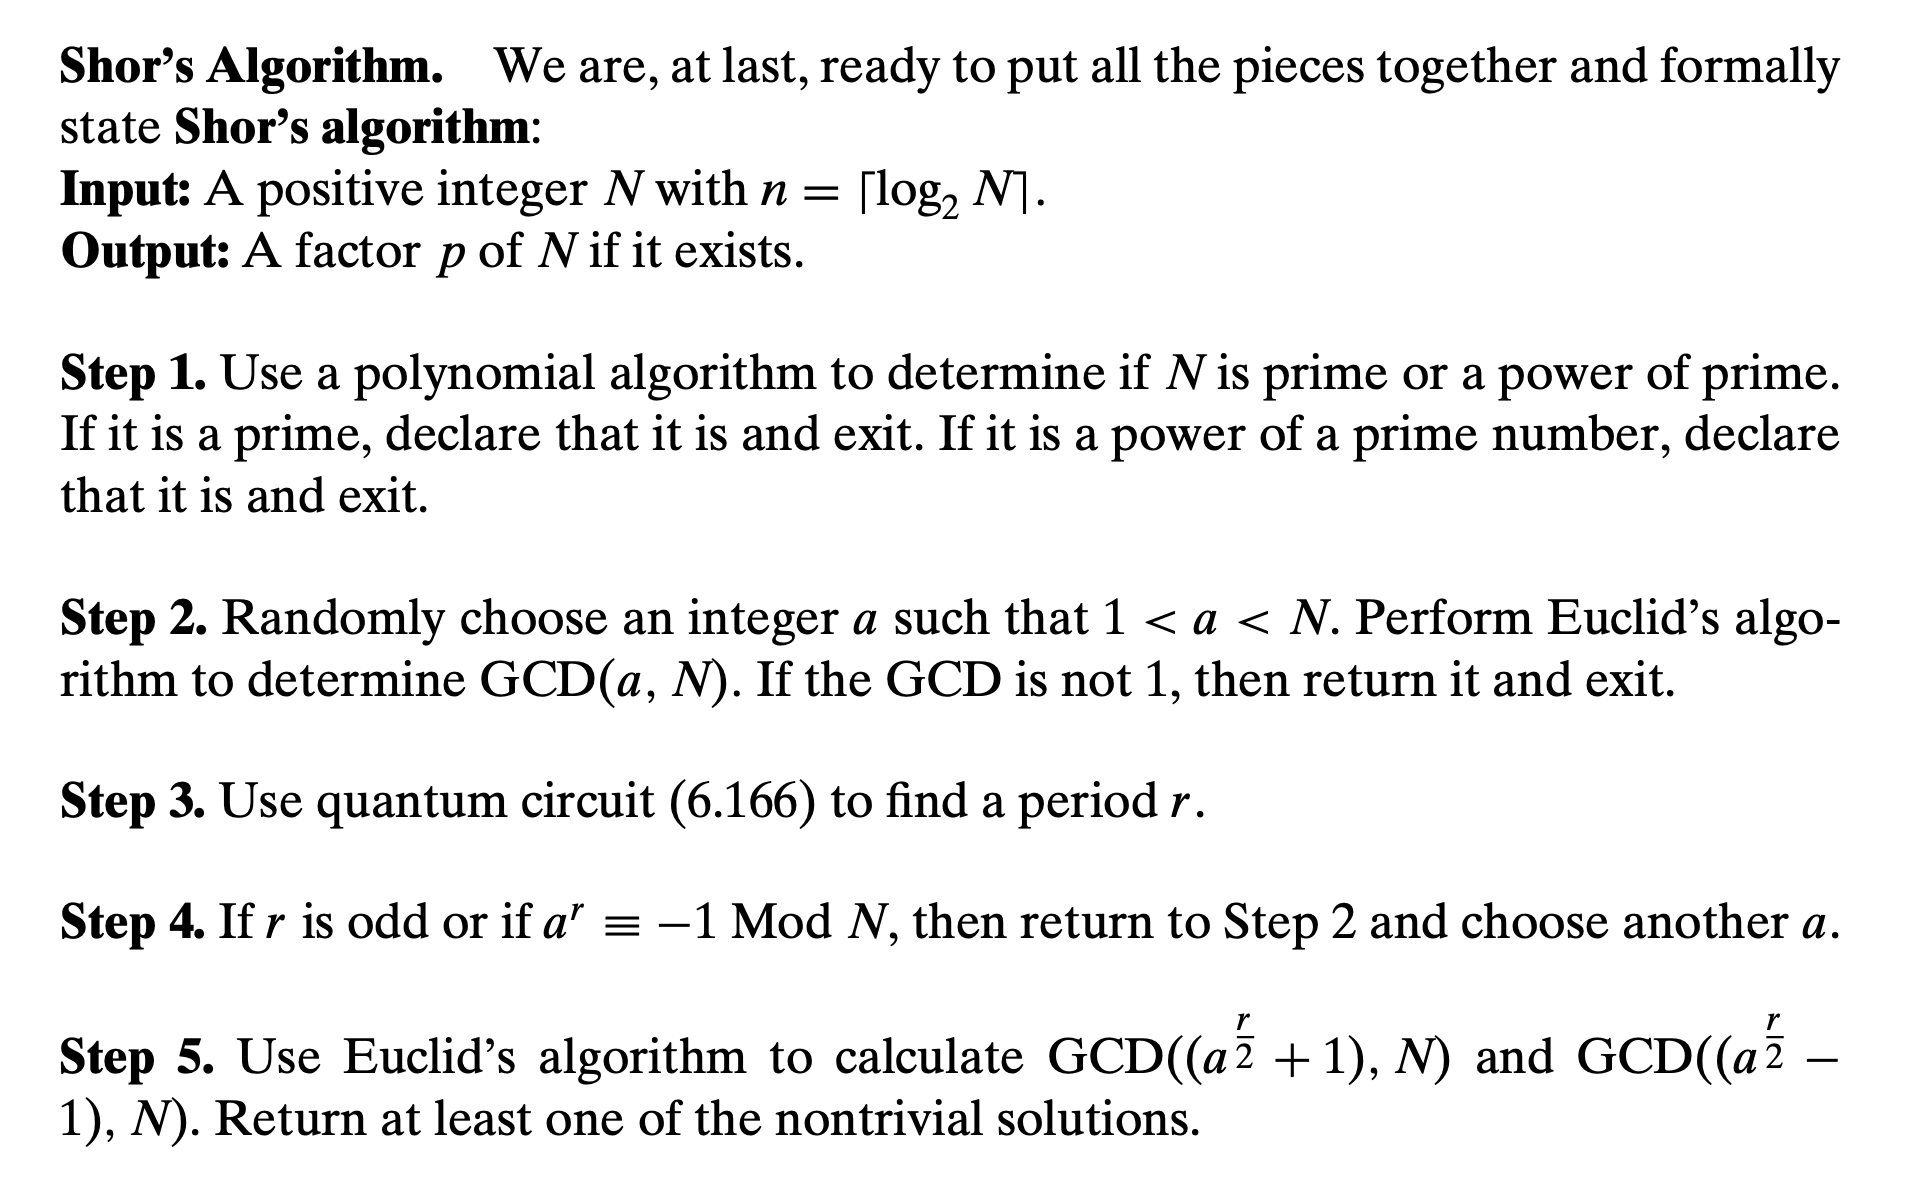

> - Yanofsky, N. S., & Mannucci, M. A. (2008). Quantum Computing for Computer Scientists. Cambridge University Press. 
---

## Step 1&2: Determining `N` & `a`
- Use a polynomial algorithm to determine if `N` is prime or a power of prime.

- $1<$ `a` $<N$.

- `n_len` $=log_2 N$.

- `m_len` $=2\times$ `n_len`.

In [166]:
N=143
a=2
n_len = math.ceil(math.log2(N))
m_len = 2*n_len

In [167]:
if isprime(N):
    print(f"{N} is a prime number")
else:
    print(f"{N} is not a prime number")

143 is not a prime number


[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00000010 | 2^1 mod 143 (bin) = 2
00000011 | x_gates


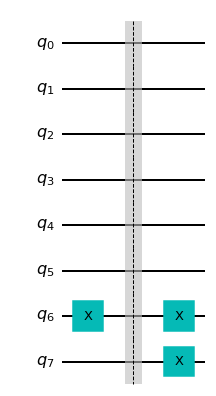

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00000100 | 2^2 mod 143 (bin) = 4
00000101 | x_gates


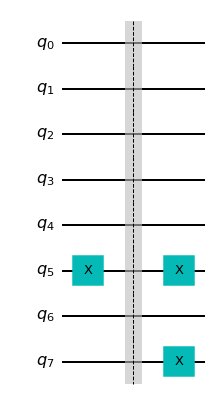

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00010000 | 2^4 mod 143 (bin) = 16
00010001 | x_gates


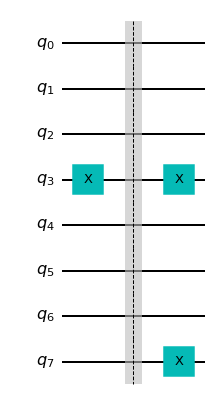

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
01110001 | 2^8 mod 143 (bin) = 113
01110000 | x_gates


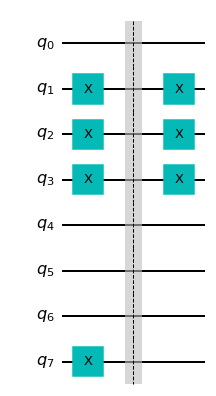

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00101010 | 2^16 mod 143 (bin) = 42
00101011 | x_gates


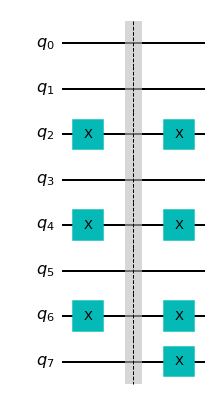

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00110000 | 2^32 mod 143 (bin) = 48
00110001 | x_gates


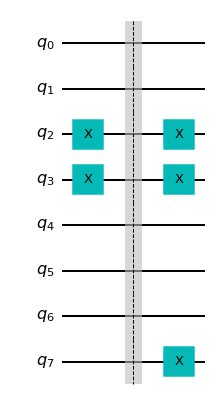

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00010000 | 2^64 mod 143 (bin) = 16
00010001 | x_gates


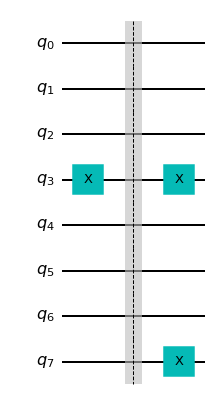

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
01110001 | 2^128 mod 143 (bin) = 113
01110000 | x_gates


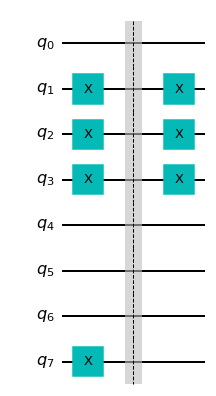

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00101010 | 2^256 mod 143 (bin) = 42
00101011 | x_gates


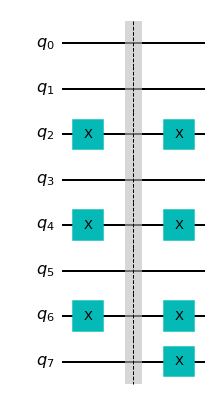

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00110000 | 2^512 mod 143 (bin) = 48
00110001 | x_gates


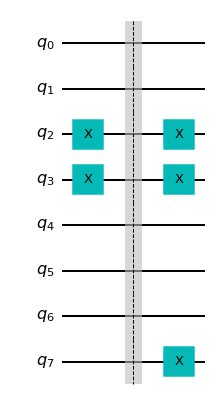

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00010000 | 2^1024 mod 143 (bin) = 16
00010001 | x_gates


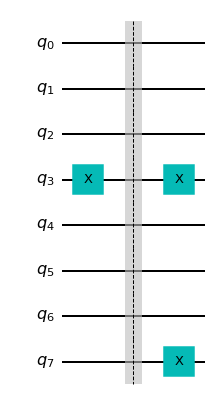

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
01110001 | 2^2048 mod 143 (bin) = 113
01110000 | x_gates


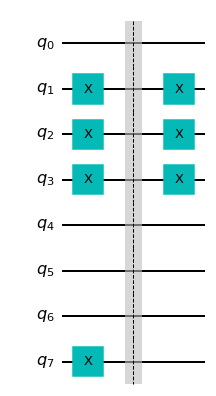

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00101010 | 2^4096 mod 143 (bin) = 42
00101011 | x_gates


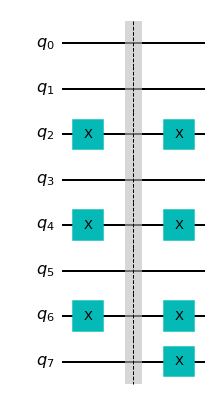

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00110000 | 2^8192 mod 143 (bin) = 48
00110001 | x_gates


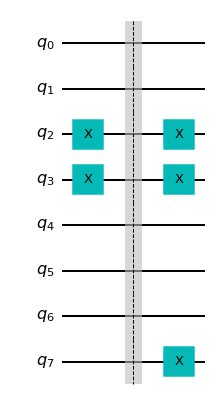

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
00010000 | 2^16384 mod 143 (bin) = 16
00010001 | x_gates


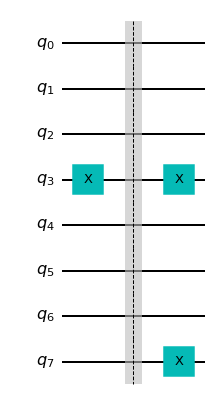

[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142]
00000010 | a(bin) = 2
01110001 | 2^32768 mod 143 (bin) = 113
01110000 | x_gates


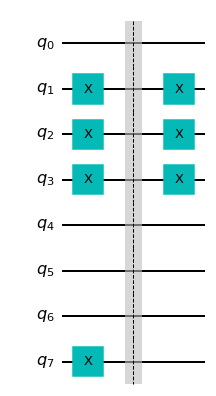

In [168]:
for p in range(m_len):
    c_amodN(a,N,2**p,draw=True)

## Step 3: Quantum Circuit to Find a Period `r`

In [169]:
# from qiskit.circuit.library import QFT

/opt/anaconda3/lib/python3.8/site-packages/qiskit/visualization/circuit/matplotlib.py:163: UserWarning: Style JSON file 'clifford.json' not found in any of these locations: /opt/anaconda3/lib/python3.8/site-packages/qiskit/visualization/circuit/styles/clifford.json, clifford.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


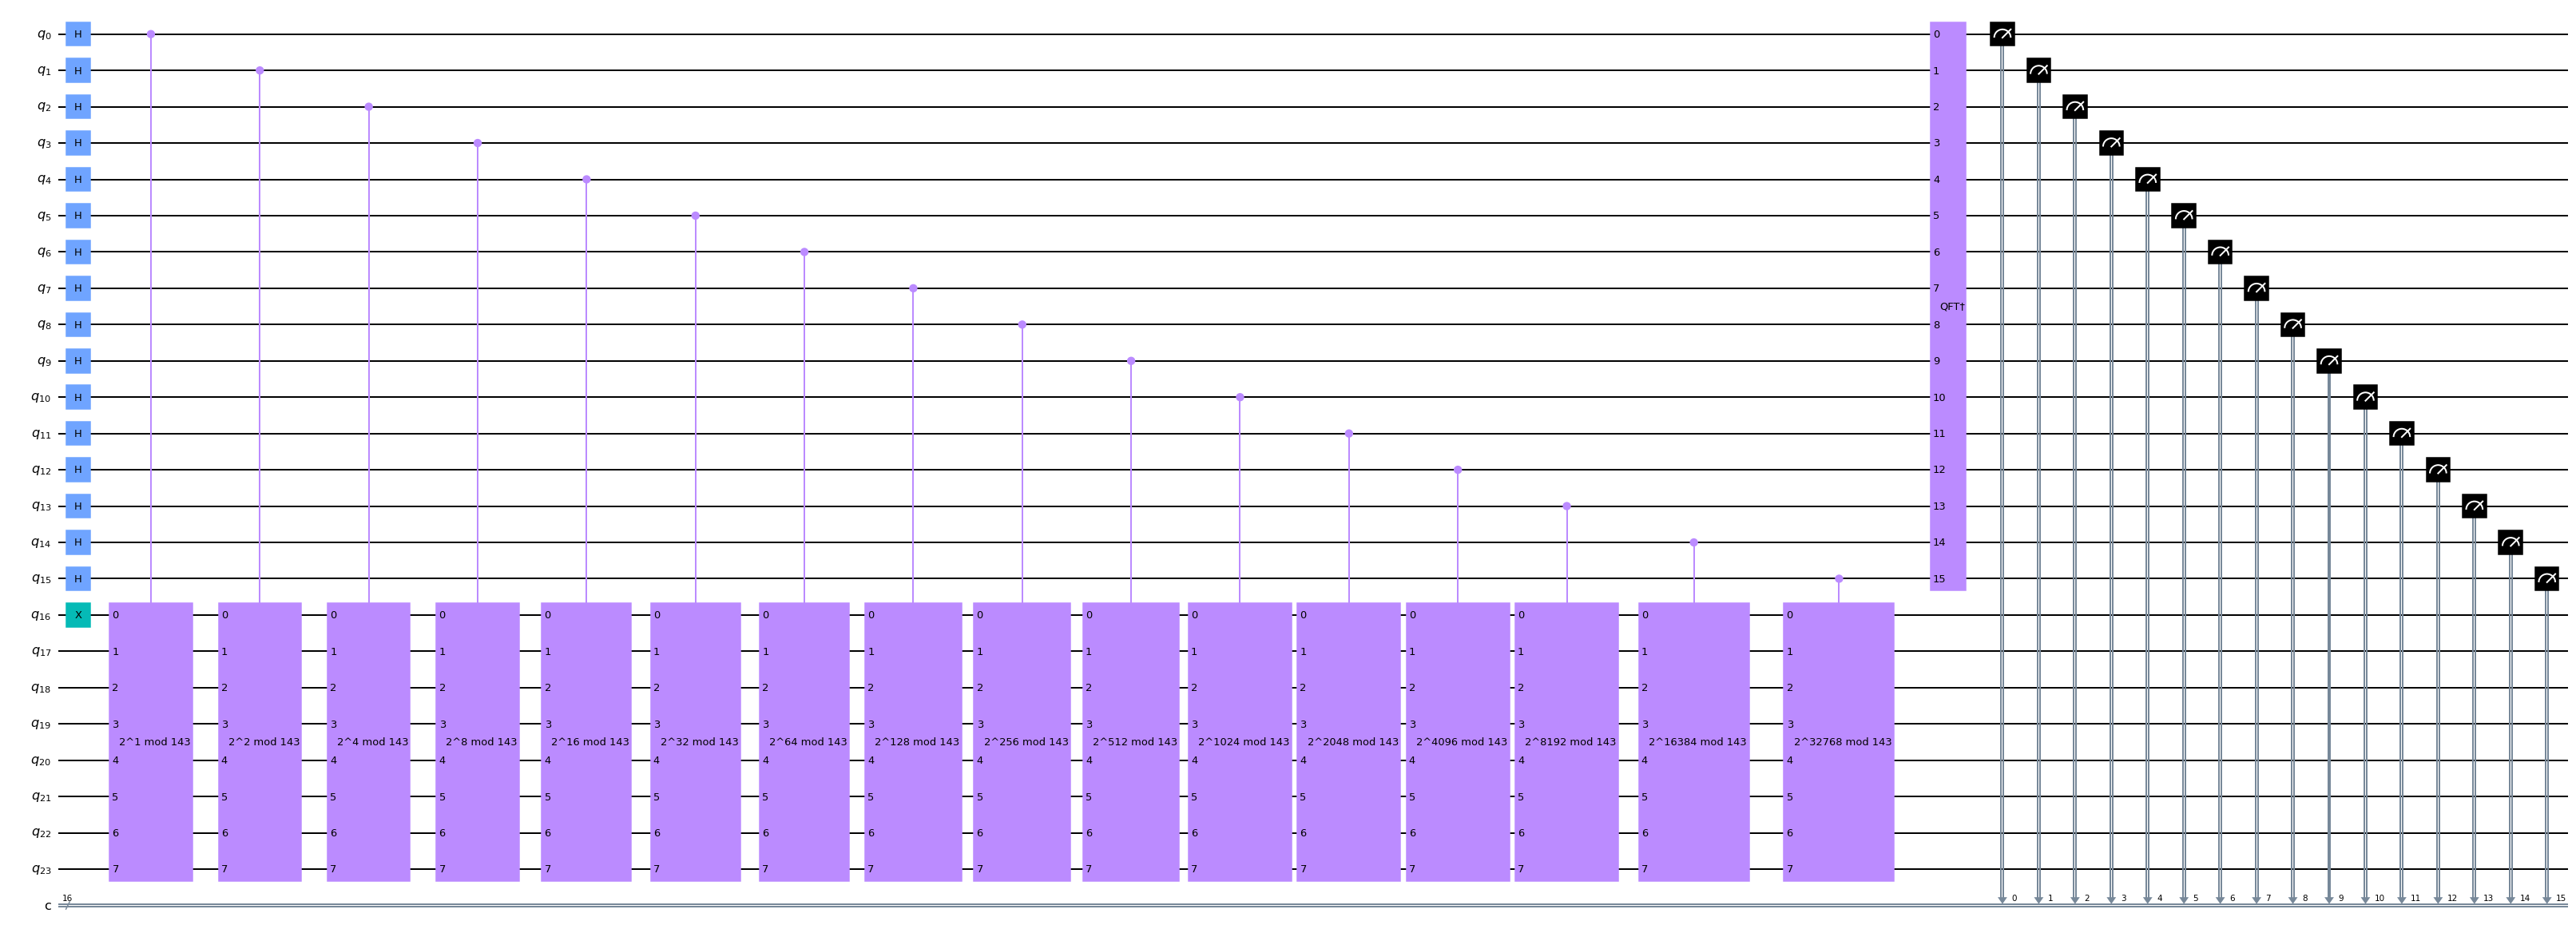

In [170]:
qc = QuantumCircuit(m_len + n_len, m_len)

# Initialize counting qubits
# in state |+>
for q in range(m_len):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(m_len)

# Do controlled-U operations
for q in range(m_len):
    qc.append(c_amodN(a, N, 2**q),
             [q] + [i+m_len for i in range(n_len)])

# Do inverse-QFT
qc.append(qft_dagger(m_len), range(m_len))
# qc.append(QFT(m_len, inverse=True), range(m_len))
# qc.append(QFT(m_len).inverse(), range(m_len))


# Measure circuit
qc.measure(range(m_len), range(m_len))
# qc.draw(fold=-1)
qc.draw(fold=-1, output='mpl', style='clifford')  # -1 means 'do not fold'

In [171]:
# counts = run_on_simulation(qc).get_counts()
# plot_histogram(counts, figsize=(17, 5))

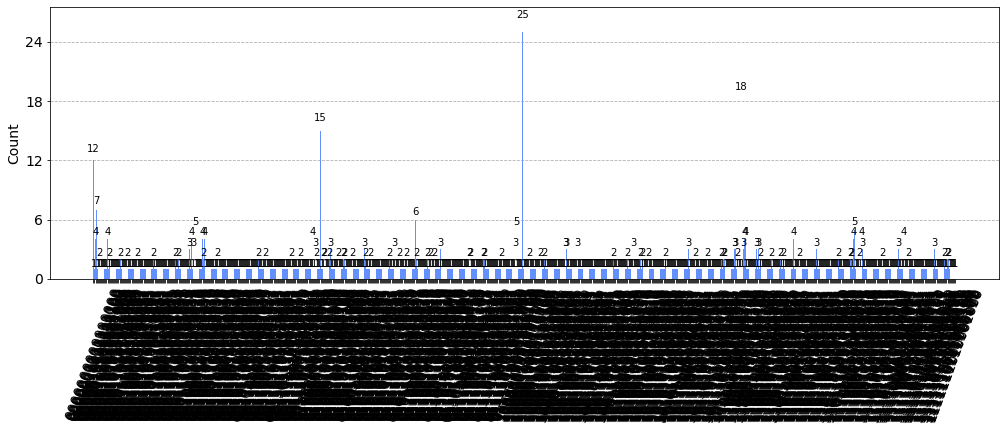

Outliers: {'0100000000000000': 15, '1000000000000000': 25, '0000001111000100': 7, '0101110111011110': 6, '0000000000000000': 12, '1100000000000000': 18}


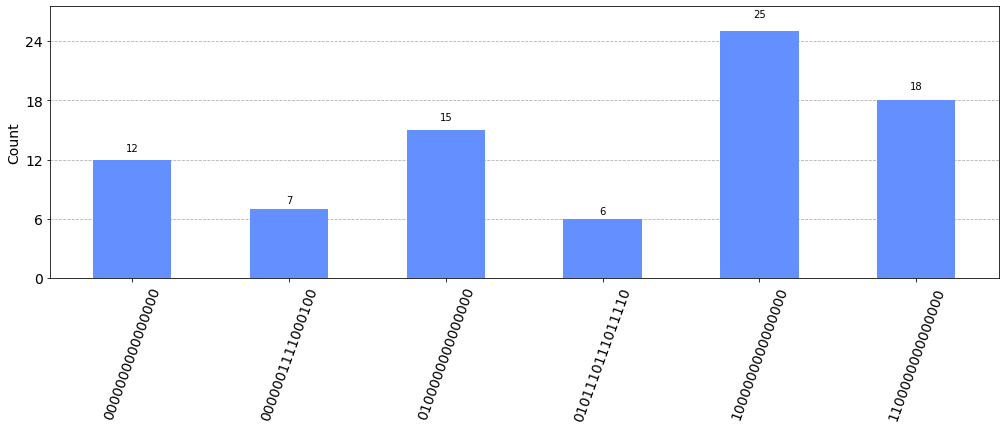

In [172]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
display(plot_histogram(counts, figsize=(17, 5)))


values = list(counts.values())
mean = np.mean(values)
std_dev = np.std(values)

# Define a threshold for outliers
threshold = 3 * std_dev

# Identify outliers
outliers = {key: val for key, val in counts.items() if abs(val - mean) > threshold}

if outliers:
    counts = outliers
    
# Print outliers
print("Outliers:", counts)

# Plot histogram
plot_histogram(counts, figsize=(17, 5))


In [173]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**m_len)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**m_len} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                      Register Output               Phase
0  0100000000000000(bin) = 16384(dec)  16384/65536 = 0.25
1  1000000000000000(bin) = 32768(dec)  32768/65536 = 0.50
2    0000001111000100(bin) = 964(dec)    964/65536 = 0.01
3  0101110111011110(bin) = 24030(dec)  24030/65536 = 0.37
4    0000000000000000(bin) =   0(dec)      0/65536 = 0.00
5  1100000000000000(bin) = 49152(dec)  49152/65536 = 0.75


In [174]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0  0.250000      1/4            4
1  0.500000      1/2            2
2  0.014709     1/68           68
3  0.366669    11/30           30
4  0.000000      0/1            1
5  0.750000      3/4            4


In [175]:
math.gcd(a, N)

1

In [176]:
def qpe_amodN(a, N):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    qc = QuantumCircuit(n_len+m_len, m_len)
    for q in range(m_len):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(m_len) # And auxiliary register in state |1>
    for q in range(m_len): # Do controlled-U operations
        qc.append(c_amodN(a, N, 2**q),
                 [q] + [i+m_len for i in range(n_len)])
    qc.append(qft_dagger(m_len), range(m_len)) # Do inverse-QFT
    qc.measure(range(m_len), range(m_len))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**m_len)
    print(f"Corresponding Phase: {phase}")
    return phase

In [177]:
phase = qpe_amodN(a, N) # Phase = s/r
Fraction(phase).limit_denominator(N)

Register Reading: 0000101110001000
Corresponding Phase: 0.0450439453125


Fraction(5, 111)

In [178]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

111


In [179]:
guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
print(guesses)

[1, 11]


## Step 4: if $[r = Even]$ AND $[a^r \not≡ −1 Mod N]$

In [180]:
def check_r_condition(a, r, N):
    if r % 2 == 0 and pow(a, r // 2, N) != N - 1:
        return True
    else:
        return False

> The function is to check if $[r = Even]$ AND $[a^r \not≡ −1 Mod N]$

## Step 5: Return the Nontrivial Solutions

Use Euclid’s algorithm to calculate $ GCD((a^{r/2} + 1), N)$ and $GCD((a^{r/2}−1),N) $ . 
Return at least one of the nontrivial solutions.

In [181]:
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = qpe_amodN(a, N) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
#     if phase != 0 and check_r_condition(a, r, N):
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print(f"*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 0100111011110011
Corresponding Phase: 0.3083953857421875
Result: r = 107
Guessed Factors: 1 and 1

ATTEMPT 2:
Register Reading: 1101101010011010
Corresponding Phase: 0.853912353515625
Result: r = 89
Guessed Factors: 1 and 1

ATTEMPT 3:
Register Reading: 0100001011000100
Corresponding Phase: 0.26080322265625
Result: r = 23
Guessed Factors: 1 and 1

ATTEMPT 4:
Register Reading: 0000011101110111
Corresponding Phase: 0.0291595458984375
Result: r = 103
Guessed Factors: 1 and 1

ATTEMPT 5:
Register Reading: 1010111001101011
Corresponding Phase: 0.6813201904296875
Result: r = 91
Guessed Factors: 1 and 11
*** Non-trivial factor found: 11 ***
